In [2]:
import numpy as np
from time import time
import random
from functions import greedy_cycle_with_regret, local_search_steepest, calculate_cost, calculate_value, random_initial_solution
import bisect
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
def mutate(parent1: np.array, parent2: np.array, **kwargs):
    common_nodes = np.intersect1d(parent1,parent2)
    all_nodes = np.arange(200)
    np.random.shuffle(all_nodes)
    common_nodes_mask = np.apply_along_axis(lambda x: np.isin(x,common_nodes),axis=0,arr=parent1)
    parent1[~common_nodes_mask] = np.setdiff1d(all_nodes,common_nodes)[:np.count_nonzero(~common_nodes_mask)]
    return parent1

In [4]:
def mutate2(parent1: np.array,
            parent2: np.array,
            distances: np.ndarray,
            data:np.ndarray,
            run_local_search: bool = True):
    common_nodes = np.intersect1d(parent1,parent2)
    common_nodes_mask = np.apply_along_axis(lambda x: np.isin(x,common_nodes),axis=0,arr=parent1)
    offspring =  greedy_cycle_with_regret(parent1[common_nodes_mask], distances, data, 3, 0.5)
    if run_local_search:
        offspring = local_search_steepest(offspring, distances, data)
    return offspring

In [5]:
def HEA(data, distances, args=dict(running_time=10, pop_size=20, limit=50000, crossover=mutate, run_local_search=False)):
    pop = []
    for _ in range(args["pop_size"]):
        order = random_initial_solution(data)
        value = calculate_value(data, distances, order)[0]
        bisect.insort(pop, (value, order))
    start = time()
    patience = 0
#     count = 0
    iterations = 0
    while(args["running_time"] > time() - start) and patience < args["limit"]:
        parents = random.sample(pop, 2)
        offspring = args["crossover"](parent1=parents[0][1],
                                      parent2=parents[1][1],
                                      distances=distances,
                                      data=data,
                                      run_local_search=args["run_local_search"])
        value = calculate_value(data, distances, offspring)[0]
        if value < pop[-1][0] and list(filter(lambda x: x[0] == value, pop)) == []:
            pop.pop()
            bisect.insort(pop, (value, offspring))
            patience = 0
#             count += 1
#             print(count,c2)
        else:
            patience += 1
        iterations += 1
#     print(count, patience)
    return calculate_value(data, distances, pop[0][1]), iterations

In [6]:
def evaluate(func, data, n=20, args=None):
    print(func, args)
    distances = calculate_cost(data)
    total, worst_value, best_value, best_solution = 0, 0, float('inf'), None
    total_time, worst_time, best_time = 0,0,float('inf')
    total_iterations, most_iterations, least_iterations = 0,0,float('inf')
    for _ in tqdm(range(n)):
        start = time()
        (value, solution), iterations = func(data, distances, args)
        elapsed = time() - start
        total_time += elapsed
        if elapsed < best_time:
            best_time = elapsed
        worst_time = max(worst_time, elapsed)


        total += value
        if value < best_value:
            best_solution = solution
            best_value = value
        worst_value = max(worst_value, value)

        total_iterations += iterations
        least_iterations = min(least_iterations, iterations)
        most_iterations = max(most_iterations, iterations)

    return dict(average_score=total / n,
                worst_score=worst_value,
                best_score=best_value,
                solution=np.array(best_solution).T,
                average_time=total_time / n,
                worst_time= worst_time,
                best_time = best_time,
                average_iterations=total_iterations / n,
                most_iterations=most_iterations,
                least_iterations=least_iterations)

In [7]:
def summarize(func, data, title, args):
    evaluation_results = evaluate(func=func,
                                    data=data,
                                     n = 1,
                                     args = args)
    (x, y, z) = evaluation_results["solution"]
    print(f'{title}:')
    print(f'average time: {evaluation_results["average_time"]}\tworst time: {evaluation_results["worst_time"]}\tbest time: {evaluation_results["best_time"]}')
    print(f'average iterations: {evaluation_results["average_iterations"]}\tmost iterations: {evaluation_results["most_iterations"]}\tleast iterations: {evaluation_results["least_iterations"]}')
    print(f'average score: {evaluation_results["average_score"]}\tworst score: {evaluation_results["worst_score"]}\tbest score: {evaluation_results["best_score"]}')
    print('Best solution:')

    plt.figure(figsize=(15,10))
    plt.scatter(data[:,0], data[:,1], np.full(data[:,0].size, 100), data[:,2], cmap='gray_r')
    plt.clim(0, 1000)
    plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
    plt.plot(x, y, 'r')
    plt.xlim([-100, 4100])
    plt.ylim([-100, 2100])
    plt.title(title)
    plt.show()
    return evaluation_results

In [8]:
data = np.loadtxt('TSPC.csv', dtype=int, delimiter=';')
distances = calculate_cost(data)

<function HEA at 0x7fc4fdbbc950> {'running_time': 20, 'pop_size': 20, 'limit': 50000, 'crossover': <function mutate2 at 0x7fc53438aae8>, 'run_local_search': False}



HEA:
average time: 20.008879899978638	worst time: 20.008879899978638	best time: 20.008879899978638
average iterations: 8129.0	most iterations: 8129	least iterations: 8129
average score: 115795.0	worst score: 115795.0	best score: 115795.0
Best solution:


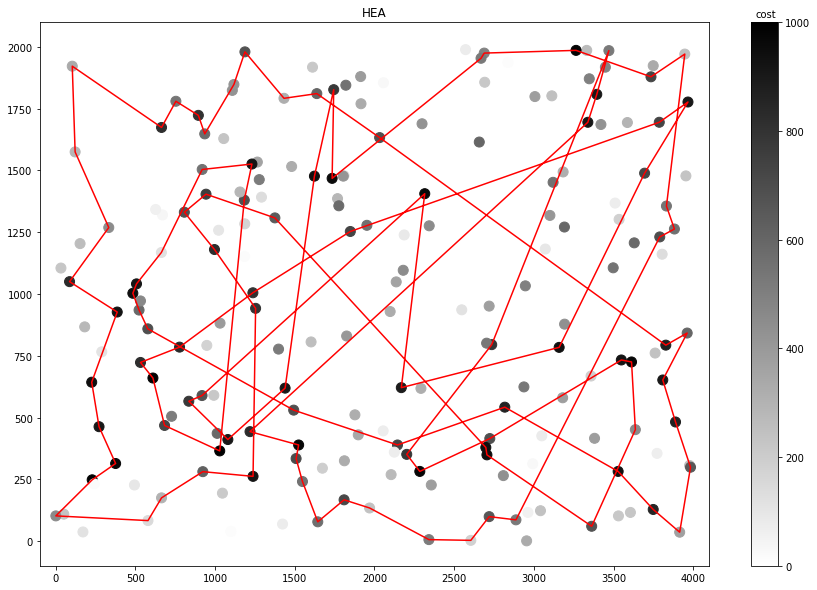

In [9]:
args = dict(
    running_time=20,
    pop_size=20,
    limit=50000,
    crossover=mutate2,
    run_local_search=False)
_ = summarize(HEA, data, 'HEA', args)